## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score, accuracy_score
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
70669,00017424_035.png,No Finding,35,17424,14,M,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00017424_035.png
94135,00023935_000.png,No Finding,0,23935,35,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00023935_000.png
57606,00014273_003.png,No Finding,3,14273,29,F,PA,2642,2365,0.143,0.143,NaN,/data/images_007/images/00014273_003.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
df = all_xray_df
# Todo

all_findings = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
for label in all_findings:
    df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
df['pneumonia_class'] = df['Pneumonia'].map(lambda x : 'pneumonia' if x == 1 else 'no_pneumonia')

## Create your training and testing data:

In [10]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    
    train_df, val_df = train_test_split(df, test_size = 0.2, stratify = df['Pneumonia'])
    
    np_count = train_df[train_df['Pneumonia'] == 0].index.tolist()
    p_count = train_df[train_df['Pneumonia'] == 1].index.tolist()
    
    np_sample = sample(np_count, len(p_count))
    
    train_df = train_df.loc[np_sample + p_count]
    
    np_count = val_df[val_df['Pneumonia'] == 0].index.tolist()
    p_count = val_df[val_df['Pneumonia'] == 1].index.tolist()
    
    np_sample = sample(np_count, 4 * len(p_count))
    
    val_df = val_df.loc[np_sample + p_count]

    
    return train_df, val_df

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [11]:
def my_image_augmentation(train = True):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    if train == True:
        my_idg = ImageDataGenerator(rescale = 1 / 255.,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range=0.15,
                                   zoom_range=0.12)
    else:
        my_idg = ImageDataGenerator(rescale = 1 / 255.)
    
    return my_idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation(train = True)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (512, 512), 
                                         batch_size = 32)

    return train_gen


def make_val_gen(val_df):
    
    my_val_idg = my_image_augmentation(train = False)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (512, 512), 
                                             batch_size = 64) 
    
    return val_gen

In [12]:
train_df, val_df = create_splits(df)

In [13]:
train_df['Pneumonia'].value_counts()

1.0    1145
0.0    1145
Name: Pneumonia, dtype: int64

In [14]:
val_df['Pneumonia'].value_counts()

0.0    1144
1.0     286
Name: Pneumonia, dtype: int64

In [15]:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(val_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [11]:
train_gen.class_indices

{'no_pneumonia': 0, 'pneumonia': 1}

In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

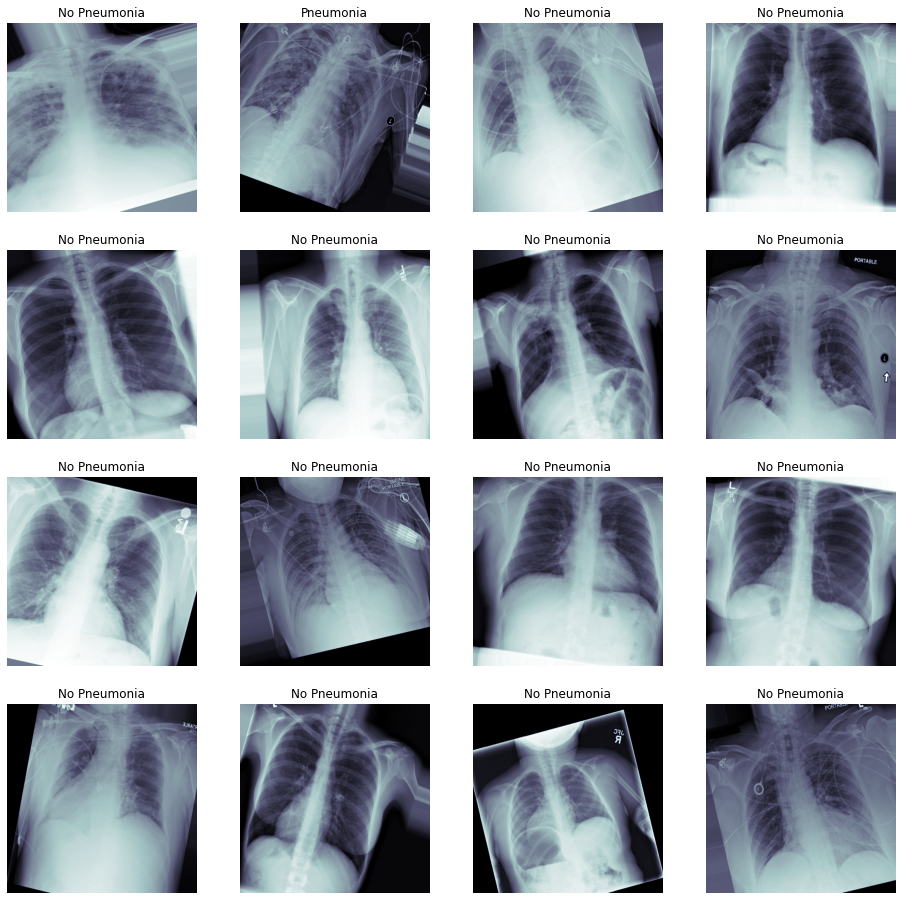

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
model = VGG16(include_top=False, weights='imagenet')
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [15]:
def load_pretrained_model():
    
    model = VGG16(include_top=False, weights='imagenet', input_shape = (512, 512, 3))
    
    return model


In [16]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    vgg_model = load_pretrained_model()
    
    for layer in vgg_model.layers[:17]:
        layer.trainable = False
        
    my_model = Sequential()
    
    my_model.add(vgg_model)
    
    my_model.add(GlobalAveragePooling2D())
    
    my_model.add(Dense(256, activation='relu'))
    
    my_model.add(BatchNormalization())
    
    my_model.add(Dropout(0.4))
    
    my_model.add(Dense(64, activation='relu'))
    
    my_model.add(BatchNormalization())
    
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(32, activation='relu'))
    
    my_model.add(BatchNormalization())
    
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [21]:
optimizer = Adam(lr=3e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [22]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.h5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

my_model = build_my_model()

my_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [23]:
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)               

### Start training! 

In [24]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
179/179 [==============================] - 542s 3s/step - loss: 0.7762 - binary_accuracy: 0.5577 - val_loss: 0.6009 - val_binary_accuracy: 0.7958

Epoch 00001: val_loss improved from inf to 0.60091, saving model to xray_class_my_model.h5
Epoch 2/10
179/179 [==============================] - 469s 3s/step - loss: 0.6715 - binary_accuracy: 0.6341 - val_loss: 0.7332 - val_binary_accuracy: 0.6280

Epoch 00002: val_loss did not improve from 0.60091
Epoch 3/10
179/179 [==============================] - 476s 3s/step - loss: 0.6111 - binary_accuracy: 0.6870 - val_loss: 0.5679 - val_binary_accuracy: 0.6930

Epoch 00003: val_loss improved from 0.60091 to 0.56787, saving model to xray_class_my_model.h5
Epoch 4/10
179/179 [==============================] - 470s 3s/step - loss: 0.5686 - binary_accuracy: 0.7270 - val_loss: 0.3914 - val_binary_accuracy: 0.7944

Epoch 00004: val_loss improved from 0.56787 to 0.39142, saving model to xray_class_my_model.h5
Epoch 5/10
179/179 [================

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [25]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 3s 52ms/step


In [26]:
def plot_roc_curve(ground_truth, probability):
    ## YOUR CODE HERE
    fpr, tpr, _ = roc_curve(ground_truth, probability)
    plt.figure(figsize = (12, 8))
    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label = f"Pneumonia AUC Score: {auc(fpr, tpr)}")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-Curve')
    plt.legend()

## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_curve(gt, prob):
    
    precision, recall, threshold = precision_recall_curve(gt, prob)
    
    plt.figure(figsize = (12, 8))
    plt.style.use("ggplot")
    plt.plot(recall, precision, label =  f"Pneumonia AP Score: {average_precision_score(gt, prob)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-Curve')
    plt.legend()
    
def f1_score(p, r):
    if(p == 0 or r == 0):
        return 0
    return 2 * p * r / (p + r)

#Also consider plotting the history of your model training:

def plot_history(history):
    
    fig, axs = plt.subplots(1, 2, figsize = (12, 5))
    axs = axs.flatten()
    plt.style.use("ggplot")
    N = len(history.history["loss"])
    
    axs[0].plot(np.arange(N), history.history["loss"], label = 'train_loss')
    axs[0].plot(np.arange(N), history.history["val_loss"], label = 'val_loss')
    axs[0].set_xlabel('# epochs')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss curve')
    axs[0].legend()
    
    axs[1].plot(np.arange(N), history.history["binary_accuracy"], label = 'train_binary_accuracy')
    axs[1].plot(np.arange(N), history.history["val_binary_accuracy"], label = 'val_binary_accuracy')
    axs[1].set_xlabel('# epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Accuracy curve')
    axs[1].legend()
    
    return

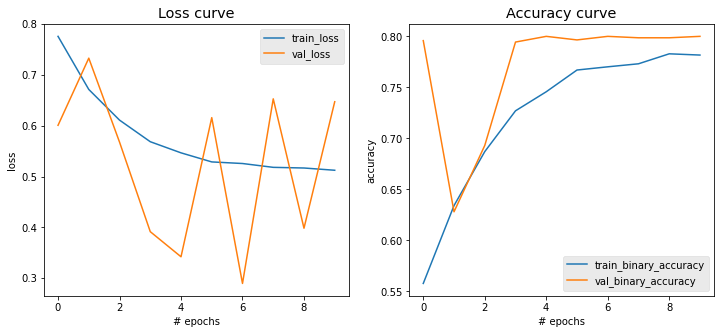

In [27]:
## plot figures
plot_history(history)

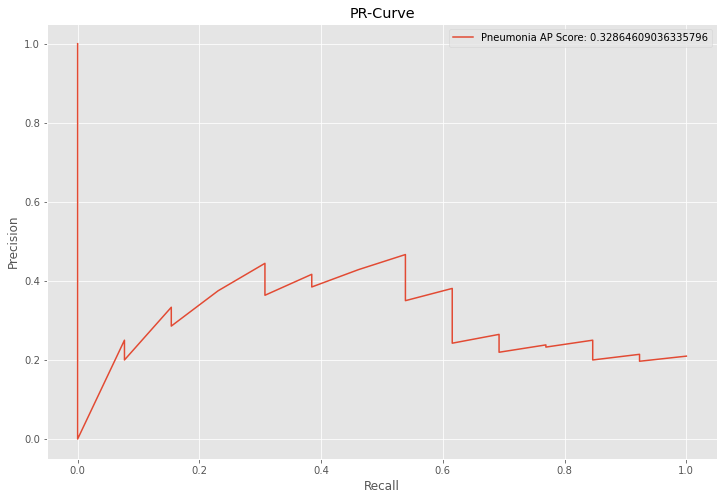

In [28]:
plot_precision_recall_curve(valY, pred_Y)

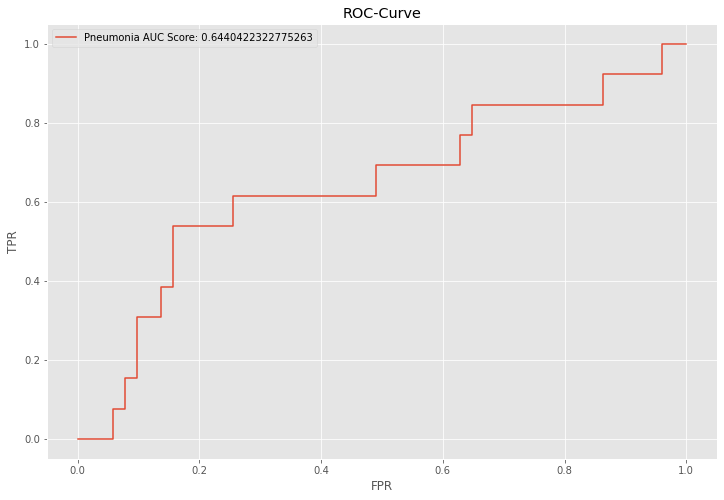

In [29]:
plot_roc_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [30]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, threshold = precision_recall_curve(valY, pred_Y.ravel())
f1_scores = [f1_score(precision[i], recall[i]) for i in range(len(threshold))]

Text(0.5, 1.0, 'F1-score on different thresholds')

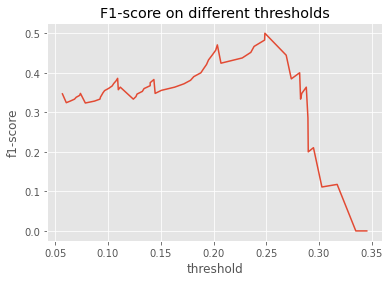

In [31]:
plt.figure()
plt.style.use("ggplot")
plt.plot(threshold, f1_scores)
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.title('F1-score on different thresholds')

In [32]:
thresh_idx = np.argmax(f1_scores)
thresh = threshold[thresh_idx]
print(f"Precision at {thresh} threshold is {precision[thresh_idx]}.")
print(f"Recall at {thresh} threshold is {recall[thresh_idx]}.")
print(f"F1 score at {thresh} threshold is {f1_scores[thresh_idx]}.")

Precision at 0.2486564964056015 threshold is 0.4666666666666667.
Recall at 0.2486564964056015 threshold is 0.5384615384615384.
F1 score at 0.2486564964056015 threshold is 0.5.


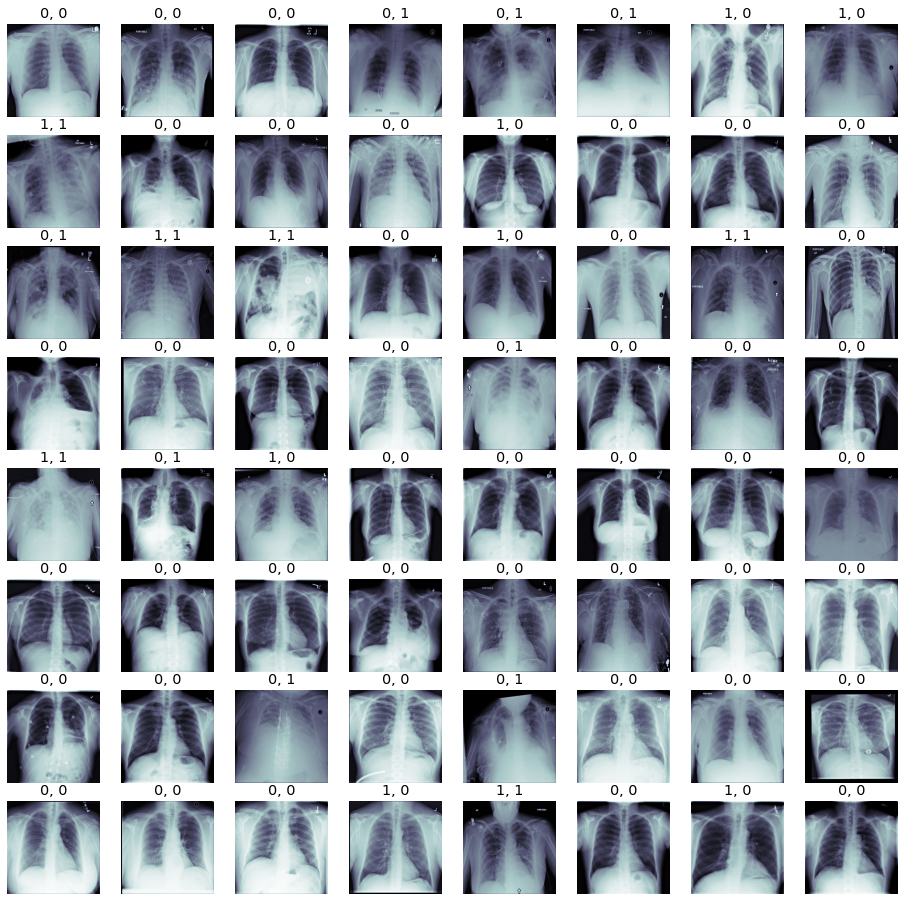

In [33]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX, valY, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [34]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)